In [39]:
import pandas as pd
import os
import glob
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set(font_scale=1)

EPSILON = 0.001
PHYS_PROPERTY = {'equate_1':'Average Diameter', 'equate_2': 'Total Surface Area', 'equate_3': 'Convex Hull'}
EXPERIMENTS = ['size', 'count', 'size-count', 'count-size', 'colors', 'colors-count']
CONGRUENT_COLUMNS = ['Ratio 50 Congruent Validation Accuracy',
                     'Ratio 56 Congruent Validation Accuracy',
                     'Ratio 63 Congruent Validation Accuracy',
                     'Ratio 71 Congruent Validation Accuracy',
                     'Ratio 75 Congruent Validation Accuracy',
                     'Ratio 86 Congruent Validation Accuracy']
INCONGRUENT_COLUMNS = ['Ratio 50 Incongruent Validation Accuracy',
                     'Ratio 56 Incongruent Validation Accuracy',
                     'Ratio 63 Incongruent Validation Accuracy',
                     'Ratio 71 Incongruent Validation Accuracy',
                     'Ratio 75 Incongruent Validation Accuracy',
                     'Ratio 86 Incongruent Validation Accuracy']

CONGRUENT_VALUE = 1
INCONGRUENT_VALUE = 0
CONGRUENCY = {CONGRUENT_VALUE: "Congruent", INCONGRUENT_VALUE: "Incongruent"}

In [2]:
def plot_multiple_traces(fig, data, x, y, y2, y3, y4, row, col, subtitle_index, subtitle):
    fig.add_trace(
        go.Scatter(x=data[x], y=data[y], name=y),
        row=row, col=col,
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=data[x], y=data[y2], name=y2),
        row=row, col=col,
        secondary_y=True,
    )

    fig.add_trace(
        go.Scatter(x=data[x], y=data[y3], name=y3),
        row=row, col=col,
        secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x=data[x], y=data[y4], name=y4),
        row=row, col=col,
        secondary_y=True,
    )

    fig.layout.annotations[subtitle_index].update(text=subtitle)

In [3]:
def plot_graph(data, title, x, y, y2, color=None, is_line_plot=True):
    if color:
        fig = make_subplots(specs=[[{"secondary_y": True}]])
        if is_line_plot:
            fig.add_trace(
            go.Scatter(x=data[x], y=data[y], name=y),
            secondary_y=False,
        )
            if y2:
                fig.add_trace(
                    go.Scatter(x=data[x], y=data[y2], name=y2),
                    secondary_y=True,
                )
        else:
            fig = px.histogram(data, x=x, y=y, color=color,  barmode='group', text_auto=True, color_discrete_sequence = px.colors.qualitative.Safe)
    else:
        if is_line_plot:
            fig = px.line(data, x=x, y=y)
        else:
            fig = px.histogram(data, x=x, y=y, color=color,  barmode='group', text_auto=True, color_discrete_sequence = px.colors.qualitative.Safe)
    fig.update_layout(
        title=title,
        xaxis_title=x,
        yaxis_title=y,)
        # coloraxis={'colorscale': 'Viridis'})
    fig.show()


In [4]:
def split_train_test_results(files_names):
    tests = []
    for file in files_names:
        if "Tested_on" in file:
            tests.append(file)
        else:
            train = file
    return tests, train

In [5]:
PATH = "/Users/gali.k/phd/phd_2021/results"
result_dict = {}
for equate in PHYS_PROPERTY.keys():
    equate_dict = {}
    for experiment in EXPERIMENTS:
        curr_results_path = PATH + os.sep + equate + os.sep + experiment
        result_file_names = glob.glob(curr_results_path + os.sep + f"Results_*.csv")
        if len(result_file_names) > 0:
            tests, training_result_file_name = split_train_test_results(result_file_names)
            testing_file_name1 = tests[0]
            testing_file_name2 = tests[1]
            training_result_df =  pd.read_csv(training_result_file_name)
            testing_file_1_df =  pd.read_csv(testing_file_name1)
            testing_file_1_df['Tested_On_Equate'] = testing_file_name1[testing_file_name1.find('Tested_on'): testing_file_name1.find('AvgAccuracy')-1].replace('Tested_on_Equate', 'equate')
            testing_file_2_df =  pd.read_csv(testing_file_name2)
            testing_file_2_df['Tested_On_Equate'] = testing_file_name2[testing_file_name2.find('Tested_on'): testing_file_name2.find('AvgAccuracy')-1].replace('Tested_on_Equate', 'equate')

            equate_dict.update({experiment: { "train" : training_result_df,
                                "test_1": testing_file_1_df,
                                "test_2": testing_file_2_df}})
            result_dict.update({equate: equate_dict})



In [6]:
def percent_diff(v1, v2):
    return np.round(np.abs(v1-v2)/((v1+v2)/2), 3)

In [7]:
def fix_losses_bug(df, acc_series_name, loss_series_name):
    acc_series = df[acc_series_name]
    loss_series = df[loss_series_name]
    for i, loss_val in enumerate(loss_series):
        if loss_val > 10:#(a bug in loss caused weird loss values (higher than usual - so adjusting the value according to the accuracy improvement)
            if i == 0: # if this is the first cell and needs to be fixed, we will compare to next gen
                if acc_series.values[i+1] >= acc_series.values[i]:# we will improve next gen we are sucks now
                    loss_series.values[i] = loss_series.values[i+1] + loss_series.values[i+1] * percent_diff(acc_series.values[i+1], acc_series.values[i])
                else:
                     loss_series.values[i] = loss_series.values[i+1] - loss_series.values[i+1] * percent_diff(acc_series.values[i+1], acc_series.values[i])
            else:# is this is not the first cell, we can compare to prev gen
                if acc_series.values[i] >= acc_series.values[i-1]: # we have improved in acc
                    loss_series.values[i] =  loss_series.values[i-1] - loss_series.values[i-1] * percent_diff(acc_series.values[i], acc_series.values[i-1]) # so our loss is better too
                else:# we don't have an improvement in acc
                    loss_series.values[i] =  loss_series.values[i-1] + loss_series.values[i-1] * percent_diff(acc_series.values[i], acc_series.values[i-1])# so out loss is sucks too
    return df

In [8]:
def add_congruency(df):
    column_names = list(df.columns)
    new_df = pd.DataFrame()
    for col in column_names:
        curr_df = pd.DataFrame()
        if "Incongruent" in col:
            curr_df[col.replace('Incongruent', '')] = df[col]
            curr_df["Congruency"] = 0
        elif "Congruent" in col:
            curr_df[col.replace('Congruent', '')] = df[col]
            curr_df["Congruency"] = 1
        else:
           curr_df[col] = df[col]
        new_df = pd.concat([new_df, curr_df])
    return new_df


In [46]:
def fix_acc_vals(s):
    result = s.apply(lambda x: 1.0 if x > 1 else x)
    return result

Analysis #1: Trained on stimuli X and tested on Y

In [53]:
def process_df(agg_df, curr_df, trained_on, tested_on, task):
    last_gen = curr_df['Generations'].max()

    columns_to_keep = CONGRUENT_COLUMNS.copy()
    columns_to_keep.append('Subject_UID')
    cong_df = curr_df.query(f"Generations == {last_gen}")[columns_to_keep]
    cong_df['Congruency'] = CONGRUENT_VALUE

    columns_to_keep = INCONGRUENT_COLUMNS.copy()
    columns_to_keep.append('Subject_UID')
    incong_df = curr_df.query(f"Generations == {last_gen}")[columns_to_keep]
    incong_df['Congruency'] = INCONGRUENT_VALUE

    validation_acc_cong = pd.DataFrame()
    validation_acc_cong['Validation Accuracy'] = [fix_acc_vals(cong_df[CONGRUENT_COLUMNS].mean().reset_index()[0]).mean()]
    validation_acc_cong['Congruency'] = [CONGRUENT_VALUE]
    validation_acc_cong['Train'] = [trained_on]
    validation_acc_cong['Test'] = [tested_on]
    validation_acc_cong['Train & Test'] = ['train: ' + trained_on + '<br>' + 'test: ' + tested_on]
    validation_acc_cong['Task'] = [task]
    validation_acc_incong = pd.DataFrame()
    validation_acc_incong['Validation Accuracy'] = [fix_acc_vals(incong_df[INCONGRUENT_COLUMNS].mean().reset_index()[0]).mean()]
    validation_acc_incong['Congruency'] = [INCONGRUENT_VALUE]
    validation_acc_incong['Train'] = [trained_on]
    validation_acc_incong['Test'] = [tested_on]
    validation_acc_incong['Train & Test'] = ['train: ' + trained_on + '<br>' + 'test: ' + tested_on]
    validation_acc_incong['Task'] = [task]
    agg_df = pd.concat([agg_df, validation_acc_cong])
    agg_df = pd.concat([agg_df, validation_acc_incong])
    return agg_df

In [54]:
final_df = pd.DataFrame()
for phys_prop in result_dict.keys():
    cross_exp_analysis_df = pd.DataFrame()
    exp_result = result_dict[phys_prop]
    for exp in exp_result.keys():
        train_df = exp_result[exp]['train']
        final_df = process_df(final_df, train_df, PHYS_PROPERTY[phys_prop], PHYS_PROPERTY[phys_prop], exp)
        test1_df = exp_result[exp]['test_1']
        final_df = process_df(final_df, test1_df, PHYS_PROPERTY[phys_prop], PHYS_PROPERTY[test1_df['Tested_On_Equate'][0]], exp)
        test2_df = exp_result[exp]['test_2']
        final_df = process_df(final_df, test2_df, PHYS_PROPERTY[phys_prop], PHYS_PROPERTY[test2_df['Tested_On_Equate'][0]], exp)


In [55]:
tasks = list(final_df['Task'].unique())

Heatmaps for different physical properties

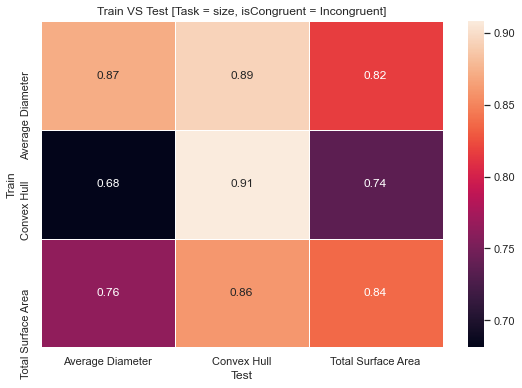

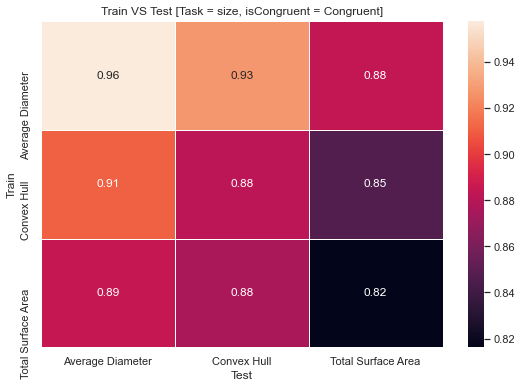

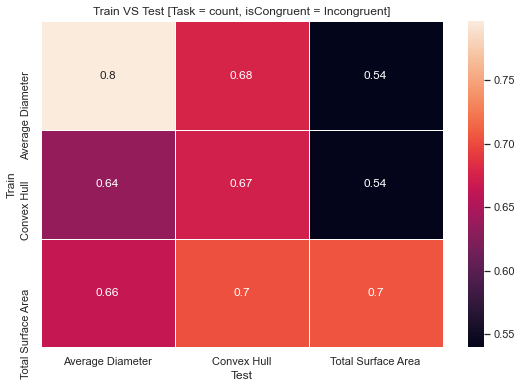

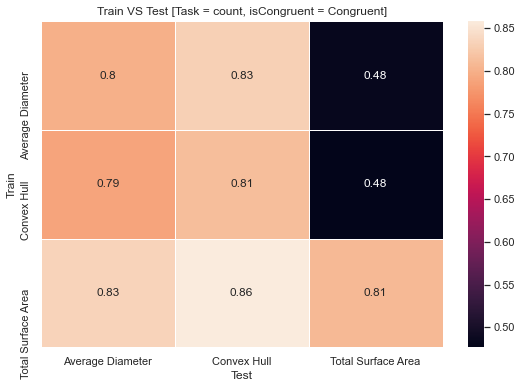

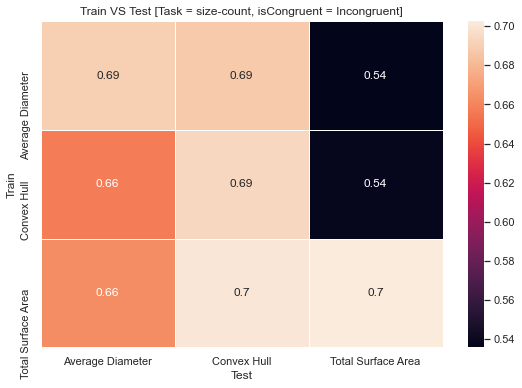

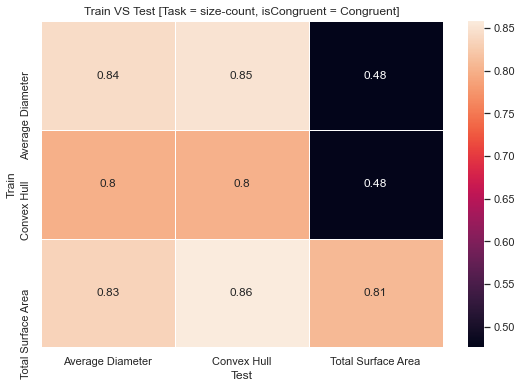

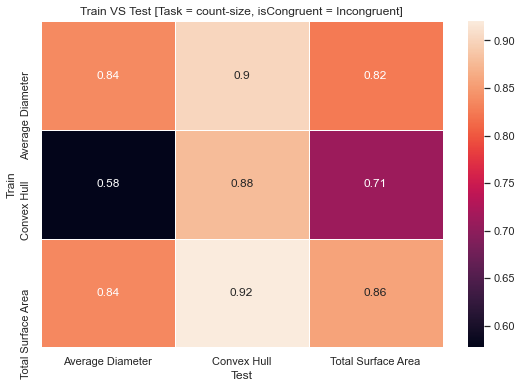

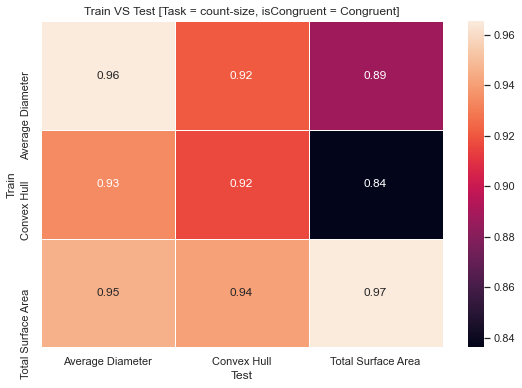

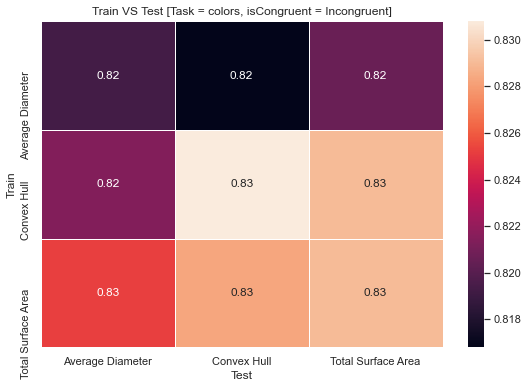

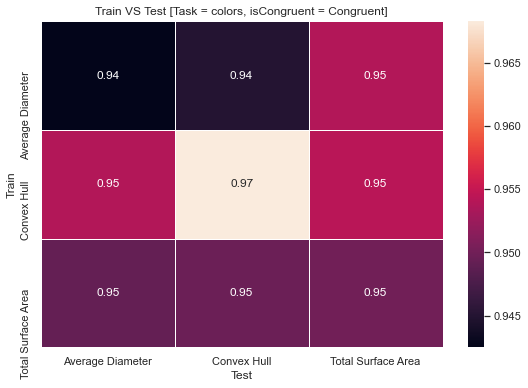

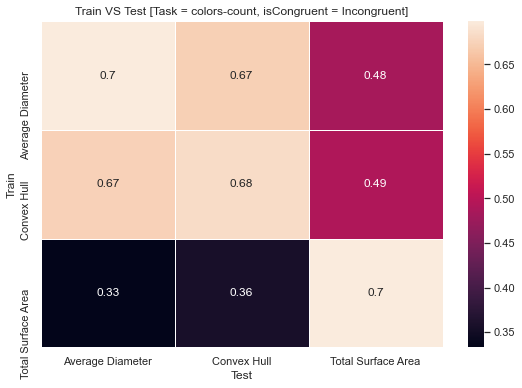

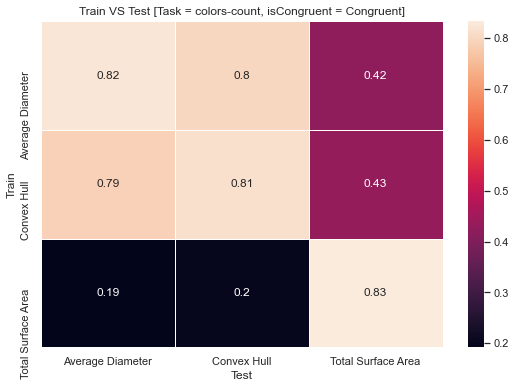

In [56]:
congruency_vals = [0, 1]
for task in tasks:
    for cong_val in congruency_vals:
        task_df = final_df.query(f"Task == '{task}' & Congruency == {cong_val}")
        task_df = task_df[['Train', 'Test', 'Validation Accuracy']]
        df_for_heatmap = pd.pivot_table(task_df, values='Validation Accuracy', index='Train', columns='Test')
        f, ax = plt.subplots(figsize=(9, 6))
        df_for_heatmap = df_for_heatmap.round(decimals=4)
        sns.heatmap(df_for_heatmap, annot=True, linewidths=.5, ax=ax).set(title=f"Train VS Test [Task = {task}, isCongruent = {CONGRUENCY[cong_val]}]")


In [57]:

for task in tasks:
    plot_graph(final_df.query(f"Task == '{task}'"), f'Task = {task}: Train and test on stimuli with different physical properties', 'Train & Test', 'Validation Accuracy', None, color='Congruency', is_line_plot=False)

In [ ]:
tasks = list(final_df['Task'].unique())
for task in tasks:
    plot_graph(final_df.query(f"Task == '{task}'"), f'Task = {task}: Train and test on stimuli with different physical properties', 'Train & Test', 'Validation Accuracy', None, color='Congruency', is_line_plot=False)
    pass

"Main step - collecting training and testing acc and loss

In [40]:
data = pd.DataFrame()
for phys_prop in result_dict.keys():
    phys_performance_df = pd.DataFrame()
    exp_result = result_dict[phys_prop]
    for exp in exp_result.keys():
        performance_df = pd.DataFrame()
        df = exp_result[exp]
        df2 = add_congruency(df)
        df = fix_losses_bug(df, 'Training_Accuracy', 'Training_Loss')
        df = fix_losses_bug(df, 'Validation_Accuracy', 'Validation_Loss')
        performance_df['Training_Accuracy'] = df.groupby(['Generations'])['Training_Accuracy'].mean()
        performance_df['Validation_Accuracy'] = df.groupby(['Generations'])['Validation_Accuracy'].mean()
        performance_df['Training_Loss'] = df.groupby(['Generations'])['Training_Loss'].mean()
        performance_df['Validation_Loss'] = df.groupby(['Generations'])['Validation_Loss'].mean()
        performance_df['Physical_property'] = phys_prop
        performance_df['Experiment'] = exp
        performance_df.reset_index(inplace=True)
        phys_performance_df = pd.concat([phys_performance_df, performance_df])
        pass
    data = pd.concat([data, phys_performance_df])
    pass
data.head(20)


KeyboardInterrupt: 

Plotting performance

In [27]:
fig = make_subplots(rows=3,cols=6,vertical_spacing=0.2,subplot_titles=("Plot 1", "Plot 2", "Plot 3", "Plot 4", "Plot 5",
                                                                       "Plot 6", "Plot 7", "Plot 8","Plot 9", "Plot 10",
                                                                       "Plot 11", "Plot 12", "Plot 13","Plot 14", "Plot 15",
                                                                       "Plot 16", "Plot 17", "Plot 18"),
                         specs=[[{"secondary_y": True},{"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}],
                                [{"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}],
                                [{"secondary_y": True}, {"secondary_y": True},{"secondary_y": True}, {"secondary_y": True},{"secondary_y": True}, {"secondary_y": True}]])
fig.print_grid()
subtitle_index = 0
for row, phys in enumerate(PHYS_PROPERTY):
    phys_df = data.query(f"Physical_property == '{phys}'")
    for col, exp in enumerate(EXPERIMENTS):
        exp_df = phys_df.query(f"Experiment == '{exp}'")
        title = f'{exp} {phys}'
        plot_multiple_traces(fig=fig, data=exp_df, x='Generations', y='Training_Accuracy', y2='Training_Loss', y3='Validation_Accuracy', y4='Validation_Loss',                              row=row+1, col=col+1, subtitle_index=subtitle_index, subtitle=title)
        subtitle_index = subtitle_index + 1
fig.update_layout(
title='Train-Test Performance',
xaxis_title='Generations',
yaxis_title='Accuracy',
coloraxis={'colorscale': 'Viridis'})
fig.show()

This is the format of your plot grid:
[ (1,1) x,y,y2      ]  [ (1,2) x2,y3,y4    ]  [ (1,3) x3,y5,y6    ]  [ (1,4) x4,y7,y8    ]  [ (1,5) x5,y10,y9   ]  [ (1,6) x6,y11,y12  ]
[ (2,1) x7,y13,y14  ]  [ (2,2) x8,y15,y16  ]  [ (2,3) x9,y17,y18  ]  [ (2,4) x10,y19,y20 ]  [ (2,5) x11,y21,y22 ]  [ (2,6) x12,y23,y24 ]
[ (3,1) x13,y25,y26 ]  [ (3,2) x14,y27,y28 ]  [ (3,3) x15,y29,y30 ]  [ (3,4) x16,y31,y32 ]  [ (3,5) x17,y33,y34 ]  [ (3,6) x18,y35,y36 ]



Finall Accuracy and Loss

In [28]:
last_gen_results_df = pd.DataFrame()
for i, phys in enumerate(PHYS_PROPERTY):
    phys_properties_df = data.query(f"Physical_property == '{phys}'")
    for j, exp in enumerate(EXPERIMENTS):
        experiment_df = phys_properties_df.query(f"Experiment == '{exp}'")
        last_gen_results_df = pd.concat([last_gen_results_df, experiment_df.query(f"Generations=={len(experiment_df)}")])

last_gen_results_df


,Generations,Training_Accuracy,Validation_Accuracy,Training_Loss,Validation_Loss,Physical_property,Experiment
9,10,0.877865,0.940215,0.670675,0.49443,equate_2,size


Validation Accuracy

In [29]:
for i, phys in enumerate(PHYS_PROPERTY):
    curr_pyhs_df = last_gen_results_df.query(f"Physical_property=='{phys}'")
    training_acc_df = pd.DataFrame()
    training_acc_df['Experiment'] = curr_pyhs_df['Experiment']
    training_acc_df['Accuracy'] = curr_pyhs_df['Training_Accuracy']
    training_acc_df['Accuracy_Type'] = 'Training'

    validation_acc_df = pd.DataFrame()
    validation_acc_df['Experiment'] = curr_pyhs_df['Experiment']
    validation_acc_df['Accuracy'] = curr_pyhs_df['Validation_Accuracy']
    validation_acc_df['Accuracy_Type'] = 'Validation'

    acc_df = pd.concat([training_acc_df, validation_acc_df])

    fig = px.bar(acc_df, x='Experiment', y='Accuracy', color='Accuracy_Type', barmode='group', text_auto=True)
    fig.update_layout(
        title=f"{PHYS_PROPERTY[phys]} Accuracy",
        xaxis_title='Experiment',
        yaxis_title='Accuracy',
        coloraxis={'colorscale': 'Viridis'})
    fig.show()

Validation Loss

In [16]:
for i, phys in enumerate(PHYS_PROPERTY):
    curr_pyhs_df = last_gen_results_df.query(f"Physical_property=='{phys}'")
    training_acc_df = pd.DataFrame()
    training_acc_df['Experiment'] = curr_pyhs_df['Experiment']
    training_acc_df['Loss'] = curr_pyhs_df['Training_Loss']
    training_acc_df['Loss_Type'] = 'Training'

    validation_acc_df = pd.DataFrame()
    validation_acc_df['Experiment'] = curr_pyhs_df['Experiment']
    validation_acc_df['Loss'] = curr_pyhs_df['Validation_Loss']
    validation_acc_df['Loss_Type'] = 'Validation'

    acc_df = pd.concat([training_acc_df, validation_acc_df])

    fig = px.bar(acc_df, x='Experiment', y='Loss', color='Loss_Type', barmode='group', text_auto=True)
    fig.update_layout(
        title=f"{PHYS_PROPERTY[phys]} Loss",
        xaxis_title='Experiment',
        yaxis_title='Loss',
        coloraxis={'colorscale': 'Viridis'})
    fig.show()

Generations

In [17]:

for i, phys in enumerate(PHYS_PROPERTY):
    curr_pyhs_df = last_gen_results_df.query(f"Physical_property=='{phys}'")

    fig = px.bar(curr_pyhs_df, x='Experiment', y='Generations', color=None, barmode='group', text_auto=True)
    fig.update_layout(
        title=f"Physical_property: {PHYS_PROPERTY[phys]}",
        xaxis_title='Experiment',
        yaxis_title='Generations',
        coloraxis={'colorscale': 'Viridis'})
    fig.show()
